## Init Cell

In [1]:
! pip install -q pandas numpy scipy matplotlib scikit-learn catboost xgboost nltk colorlog pathlib spacy seaborn optuna ipywidgets
! spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 828.1 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import os
from pathlib import Path

ROOT_DIR = Path(os.getcwd())


import logging 
import time
import json
import gc
import os  

from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, make_scorer, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pandas as pd
import joblib
from xgboost import XGBClassifier

from src.ml_utils.transformers import TextCleaner, SpacyTokenizer, TokenProcessor

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s',
     datefmt='%H:%M:%S'
 )

## Data loading & Cleaning

In [4]:
df_data = pd.read_json("data/reuters_articles_total.json")
df_data.info()
df_data.sample(5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  3942 non-null   object
 1   title       3942 non-null   object
 2   category    3942 non-null   object
 3   tags        3942 non-null   object
 4   text        3942 non-null   object
dtypes: object(5)
memory usage: 154.1+ KB


,article_id,title,category,tags,text
3358,https://www.reuters.com/business/finance/netsp...,Netspend to compensate overcharged customers i...,markets,"[RHPI:HEALTHCARE-PROVIDERS, TOPIC:WORLD-US-NEW...","NEW YORK, Jan 30 (Reuters) - Netspend, a provi..."
3522,https://www.reuters.com/markets/debt-boom-hits...,Debt boom hits pause Down Under as US election...,markets,"[MTPIX, AGN, BACT, BISV, BISV08, BIZ, CDM, COR...","SYDNEY, Oct 16 (Reuters) - Australian dollar d..."
1609,https://www.reuters.com/business/finance/lawye...,Lawyer group urges overhaul to ease US process...,business,"[MTPIX, BACT, BISV, BISV08, BIZ, BLR, BNK, BNK...",Jan 27 (Reuters) - U.S. regulators must simpli...
92,https://www.reuters.com/world/middle-east/syri...,Syria's new leaders turn to Islamic law in eff...,world,"[RSBI:HUMAN-RIGHTS, RULES:WORLD-SYRIA, INSGHT,...","DAMASCUS, Jan 23 (Reuters) - Syria's new autho..."
69,https://www.reuters.com/world/uk/uk-teenager-i...,UK teenager jailed for minimum of 52 years for...,world,"[TOPNWS, CIV, CLJ, CRIM, CWP, GEN, IMM, JUDIC,...","LONDON, Jan 23 (Reuters) - A British teenager ..."


In [15]:
from dataclasses import dataclass, field
from typing import Optional, Dict

@dataclass
class PreprocessParams:
    spacy_model: str = "en_core_web_sm"
    remove_punct: bool = True
    custom_punct: str = r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
    remove_stopwords: bool = True
    lemmatize: bool = True
    stem: bool = False
    lowercase: bool = True
    min_token_length: int = 3
    pca_components: int = 1000
    verbose: bool = True

@dataclass
class TrainingParams:
    test_size: float = 0.2
    random_state: int = 42
    shuffle_split: bool = True
    n_jobs: int = 1
    verbose: bool = True

@dataclass
class Classifier:
    name: str
    estimator: BaseEstimator
    param_grid: Optional[Dict] = field(default=None)
    search_params: bool = field(default=False)
    cv: int = field(default=3)

In [ ]:
def create_pipeline(params: PreprocessParams):
    return Pipeline([
        ('cleaner', TextCleaner(params)),
        ('tokenizer', SpacyTokenizer(params)),
        ('processor', TokenProcessor(params)),        
        ('tfidf', TfidfVectorizer()),
        ('pca', PCA(n_components=params.pca_components)),
    ], verbose=params.verbose)

def get_pipeline(params: PreprocessParams):
    cols = ['text', 'title', 'tags']
    col_transformers = [(f'{col}_pipeline', create_pipeline(params), col) for col in cols]

    column_processor = ColumnTransformer(
        transformers=[
            *col_transformers,
        ],
        remainder='drop',
        verbose=params.verbose,
    )

    return Pipeline(steps=[('column_processor', column_processor)], verbose=params.verbose)

def custom_train_test(_df: pd.DataFrame, _preprocess_params: PreprocessParams,  _train_params: TrainingParams):
    
        logging.info('Split data step has been started')
        label_encoder = LabelEncoder()
        _df['category'] = label_encoder.fit_transform(_df['category'].astype(str))

        X = _df.drop(['category'], axis=1)
        y = _df.pop('category')

        feature_pipeline = get_pipeline(_preprocess_params)
        display(feature_pipeline)
        X_transformed = feature_pipeline.fit_transform(X)

        os.makedirs(ROOT_DIR / 'pipeline_result', exist_ok=True)
        joblib.dump(X_transformed, ROOT_DIR / 'pipeline_result/X.pkl')
        joblib.dump(y, ROOT_DIR / 'pipeline_result/y.pkl')
        
        logging.info(f'Pipeline_result was saved at: {ROOT_DIR / "pipeline_result"}')

        _X_train, _X_test, _y_train, _y_test = train_test_split(
                X_transformed,
                y,
                test_size=_train_params.test_size,
                random_state=_train_params.random_state,
                shuffle=_train_params.shuffle_split
        )

        return _X_train, _X_test, _y_train, _y_test, feature_pipeline, label_encoder

def classifier_eval(_X_test, _y_test, classifier: Classifier) -> None:
    logging.info(f'Evaluation for {classifier.name}')
    
    y_pred = classifier.estimator.predict(_X_test)
    metrics_dict = classification_report(y_true=_y_test, y_pred=y_pred, output_dict=True)        
    display(pd.DataFrame(metrics_dict))    
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(_y_test, y_pred)).plot()
    
def search_params(classifier: Classifier, train_params: TrainingParams,
                       X_train, y_train):
    estimator = classifier.estimator
    param_grid = classifier.param_grid

    if param_grid is not None and classifier.search_params:
        scorer = make_scorer(accuracy_score)

        halving_random_search = HalvingRandomSearchCV(
            estimator=estimator,
            param_distributions=param_grid,
            factor=2,
            resource='n_samples',
            cv=classifier.cv,
            scoring=scorer,
            random_state=train_params.random_state,
            n_jobs=train_params.n_jobs,
            verbose=train_params.verbose
        )
        
        logging.info(f'Parameter search for {classifier.name}')
        halving_random_search.fit(X_train, y_train)
        best_estimator = halving_random_search.best_estimator_
        best_params = halving_random_search.best_params_

        logging.info(f"Best parameters for {classifier.name}:\n {best_params}")
        logging.info(f"Best estimator for {classifier.name}:\n {best_estimator}")

    else:
        best_estimator = estimator
        best_params = None
        logging.warning(f"{classifier.name} doesn't require parameter search")

    return best_estimator, best_params

def train_step(_X_train, _y_train, classifier: Classifier, train_params: TrainingParams):
    if classifier.search_params:
        best_estimator, best_params = search_params(
            classifier=classifier,
            train_params=train_params,
            X_train=_X_train,
            y_train=_y_train,
        )
        classifier.estimator = best_estimator.set_params(**best_params)
    logging.info(f'Fitting {classifier.name}')
    classifier.estimator.fit(_X_train, _y_train)
    return classifier

def test_classifier(classifier: Classifier, _train_params: TrainingParams, *args) -> None:
    gc.collect()
    _X_train, _X_test, _y_train, _y_test, x_estim, y_estim = args
    start_time = time.time()
    trained_clf = train_step(_X_train, _y_train,
           classifier=classifier,
           train_params=_train_params
    )
    logging.info(f"Train time: {time.time() - start_time:.2f}")
    classifier_eval(_X_test, _y_test, trained_clf)

In [17]:
preprocess_params = PreprocessParams()
train_params = TrainingParams()

classifiers = [
    Classifier(
        name='RidgeClassifier',
        estimator=RidgeClassifier(random_state=train_params.random_state),
        param_grid={
            'alpha': [0.1, 0.3, 1.0, 10.0, 100.0],
            'fit_intercept': [True, False],
            'class_weight': [None, 'balanced'],
            'solver': ['auto', 'svd', 'cholesky', 'sag', 'saga', 'lsqr', 'sparse_cg']
        },
        search_params=True
    ),
    Classifier(
        name='GradientBoostingClassifier',
        estimator=GradientBoostingClassifier(random_state=train_params.random_state),
        param_grid = {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.03, 0.1, 0.3],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [3, 5, 8],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'log2', 'sqrt'],
            'criterion': ['mse', 'mae', 'friedman_mse']
        },
        search_params=True
    ),
    Classifier(
        name='MLPClassifier',
        estimator=MLPClassifier(random_state=train_params.random_state),
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001],
            'learning_rate_init': [0.001, 0.01],
            'max_iter': [200, 400],
        },
        search_params=True
    ),
    Classifier(
        name='KNeighborsClassifier',
        estimator=KNeighborsClassifier(),
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'leaf_size': [10, 20, 30, 50],
            'p': [1, 2],
            'metric': ['minkowski', 'euclidean', 'chebyshev']
        },
        search_params=True
    ),
    Classifier(
        name='RandomForestClassifier',
        estimator=RandomForestClassifier(random_state=train_params.random_state),
        param_grid = {
            'n_estimators': [50, 100, 150, 200],
            'criterion': ['entropy', 'gini'],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [3, 5, 8],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'log2', 'sqrt']
        },
        search_params=True
    ),
    Classifier(
        name='XGBClassifier',
        estimator=XGBClassifier(tree_method="hist", device="cuda", random_state=train_params.random_state)
    ),
]

### Preprocess and split

In [18]:
split_data = custom_train_test(
    df_data.copy(deep=True),
    preprocess_params,
    train_params
)

[19:58:23] {/tmp/ipykernel_89065/1747248270.py:26} INFO - Split data step has been started


Pipeline(steps=[('column_processor',
                 ColumnTransformer(transformers=[('text_pipeline',
                                                  Pipeline(steps=[('cleaner',
                                                                   TextCleaner(params=PreprocessParams(spacy_model='en_core_web_sm',
                                                                                                       remove_punct=True,
                                                                                                       custom_punct='[!"#$%&\\\'()*+,-./:;<=>?@[\\\\]^_`{|}~]',
                                                                                                       remove_stopwords=True,
                                                                                                       lemmatize=True,
                                                                                                       stem=False,
                                                                                                       lowercase=True,
                                                                                                       min_token_length=3,
                                                                                                       pca_components=10...
                                                                   TokenProcessor(params=PreprocessParams(spacy_model='en_core_web_sm',
                                                                                                          remove_punct=True,
                                                                                                          custom_punct='[!"#$%&\\\'()*+,-./:;<=>?@[\\\\]^_`{|}~]',
                                                                                                          remove_stopwords=True,
                                                                                                          lemmatize=True,
                                                                                                          stem=False,
                                                                                                          lowercase=True,
                                                                                                          min_token_length=3,
                                                                                                          pca_components=1000,
                                                                                                          verbose=True))),
                                                                  ('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('pca',
                                                                   PCA(n_components=1000))],
                                                           verbose=True),
                                                  'tags')],
                                   verbose=True))],
         verbose=True)

[Pipeline] ........... (step 1 of 5) Processing cleaner, total=   0.2s
[Pipeline] ......... (step 2 of 5) Processing tokenizer, total=  37.0s
[Pipeline] ......... (step 3 of 5) Processing processor, total= 8.5min
[Pipeline] ............. (step 4 of 5) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 5 of 5) Processing pca, total= 3.5min
[ColumnTransformer] . (1 of 3) Processing text_pipeline, total=12.5min
[Pipeline] ........... (step 1 of 5) Processing cleaner, total=   0.0s
[Pipeline] ......... (step 2 of 5) Processing tokenizer, total=  14.8s
[Pipeline] ......... (step 3 of 5) Processing processor, total= 1.4min
[Pipeline] ............. (step 4 of 5) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing pca, total= 1.2min
[ColumnTransformer]  (2 of 3) Processing title_pipeline, total= 2.8min
[Pipeline] ........... (step 1 of 5) Processing cleaner, total=   0.1s
[Pipeline] ......... (step 2 of 5) Processing tokenizer, total=  43.3s
[Pipel

[20:20:44] {/tmp/ipykernel_89065/1747248270.py:41} INFO - Pipeline_result was saved at: /home/dantimson/nlp-text/nlp_hse_lab/pipeline_result


[Pipeline] ............... (step 5 of 5) Processing pca, total=  30.0s
[ColumnTransformer] . (3 of 3) Processing tags_pipeline, total= 8.7min
[Pipeline] .. (step 1 of 1) Processing column_processor, total=24.1min


In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
def warn(*args, **kwargs):
    pass
warnings.warn = warn

### Ridge

[20:32:40] {/tmp/ipykernel_89065/408107184.py:81} INFO - Parameter search for RidgeClassifier


n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 24
max_resources_: 3153
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 131
n_resources: 24
Fitting 3 folds for each of 131 candidates, totalling 393 fits
----------
iter: 1
n_candidates: 66
n_resources: 48
Fitting 3 folds for each of 66 candidates, totalling 198 fits
----------
iter: 2
n_candidates: 33
n_resources: 96
Fitting 3 folds for each of 33 candidates, totalling 99 fits
----------
iter: 3
n_candidates: 17
n_resources: 192
Fitting 3 folds for each of 17 candidates, totalling 51 fits
----------
iter: 4
n_candidates: 9
n_resources: 384
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 5
n_candidates: 5
n_resources: 768
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 3
n_resources: 1536
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 7
n_candidates: 2
n_resources: 3072
Fitting 

[20:35:10] {/tmp/ipykernel_89065/408107184.py:86} INFO - Best parameters for RidgeClassifier:
 {'solver': 'sag', 'fit_intercept': False, 'class_weight': None, 'alpha': 10.0}
[20:35:10] {/tmp/ipykernel_89065/408107184.py:87} INFO - Best estimator for RidgeClassifier:
 RidgeClassifier(alpha=10.0, fit_intercept=False, random_state=42, solver='sag')
[20:35:10] {/tmp/ipykernel_89065/408107184.py:105} INFO - Fitting RidgeClassifier
[20:35:17] {/tmp/ipykernel_89065/408107184.py:117} INFO - Train time: 157.78
[20:35:17] {/tmp/ipykernel_89065/408107184.py:54} INFO - Evaluation for RidgeClassifier


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.593939,0.674286,0.733051,0.910798,0.73891,0.728019,0.730363
recall,0.485149,0.651934,0.865000,0.941748,0.73891,0.735957,0.738910
f1-score,0.534060,0.662921,0.793578,0.926014,0.73891,0.729143,0.731741
support,202.000000,181.000000,200.000000,206.000000,0.73891,789.000000,789.000000


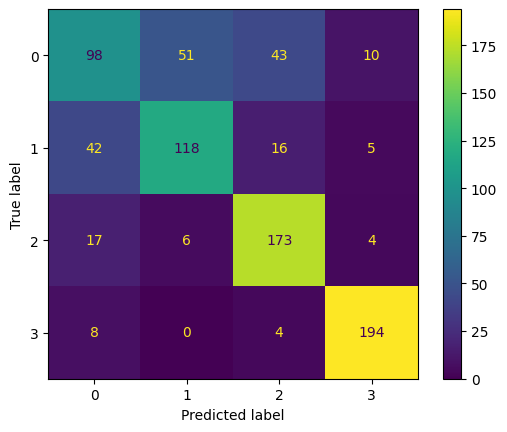

In [28]:
test_classifier(classifiers[0], train_params, *split_data)

### Gradient Boosting

[20:38:20] {/tmp/ipykernel_89065/408107184.py:81} INFO - Parameter search for GradientBoostingClassifier


n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 24
max_resources_: 3153
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 131
n_resources: 24
Fitting 3 folds for each of 131 candidates, totalling 393 fits
----------
iter: 1
n_candidates: 66
n_resources: 48
Fitting 3 folds for each of 66 candidates, totalling 198 fits
----------
iter: 2
n_candidates: 33
n_resources: 96
Fitting 3 folds for each of 33 candidates, totalling 99 fits
----------
iter: 3
n_candidates: 17
n_resources: 192
Fitting 3 folds for each of 17 candidates, totalling 51 fits
----------
iter: 4
n_candidates: 9
n_resources: 384
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 5
n_candidates: 5
n_resources: 768
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 3
n_resources: 1536
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 7
n_candidates: 2
n_resources: 3072
Fitting 

[20:55:30] {/tmp/ipykernel_89065/408107184.py:86} INFO - Best parameters for GradientBoostingClassifier:
 {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
[20:55:30] {/tmp/ipykernel_89065/408107184.py:87} INFO - Best estimator for GradientBoostingClassifier:
 GradientBoostingClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=2,
                           min_samples_split=5, n_estimators=150,
                           random_state=42)
[20:55:30] {/tmp/ipykernel_89065/408107184.py:105} INFO - Fitting GradientBoostingClassifier
[20:57:04] {/tmp/ipykernel_89065/408107184.py:117} INFO - Train time: 1123.88
[20:57:04] {/tmp/ipykernel_89065/408107184.py:54} INFO - Evaluation for GradientBoostingClassifier


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.421320,0.567839,0.722513,0.891089,0.651458,0.650690,0.653932
recall,0.410891,0.624309,0.690000,0.873786,0.651458,0.649747,0.651458
f1-score,0.416040,0.594737,0.705882,0.882353,0.651458,0.649753,0.652254
support,202.000000,181.000000,200.000000,206.000000,0.651458,789.000000,789.000000


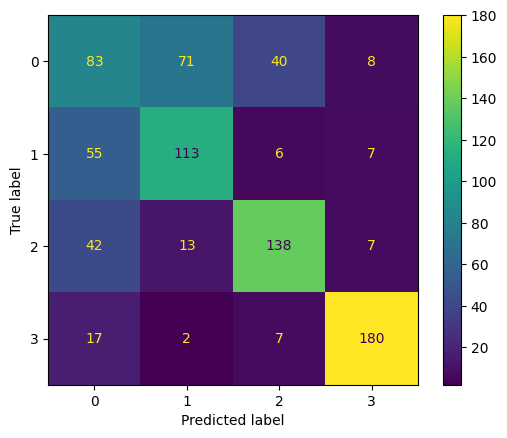

In [29]:
test_classifier(classifiers[1], train_params, *split_data)

### MLP

[21:02:02] {/tmp/ipykernel_89065/408107184.py:81} INFO - Parameter search for MLPClassifier


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 8
min_resources_: 24
max_resources_: 3153
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 32
n_resources: 24
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 16
n_resources: 48
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 8
n_resources: 96
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 4
n_resources: 192
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 384
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 5
n_candidates: 1
n_resources: 768
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[21:06:58] {/tmp/ipykernel_89065/408107184.py:86} INFO - Best parameters for MLPClassifier:
 {'solver': 'adam', 'max_iter': 400, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
[21:06:58] {/tmp/ipykernel_89065/408107184.py:87} INFO - Best estimator for MLPClassifier:
 MLPClassifier(alpha=0.001, max_iter=400, random_state=42)
[21:06:58] {/tmp/ipykernel_89065/408107184.py:105} INFO - Fitting MLPClassifier
[21:07:31] {/tmp/ipykernel_89065/408107184.py:117} INFO - Train time: 328.90
[21:07:31] {/tmp/ipykernel_89065/408107184.py:54} INFO - Evaluation for MLPClassifier


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.463158,0.590244,0.757576,0.933673,0.686946,0.686163,0.689790
recall,0.435644,0.668508,0.750000,0.888350,0.686946,0.685625,0.686946
f1-score,0.448980,0.626943,0.753769,0.910448,0.686946,0.685035,0.687550
support,202.000000,181.000000,200.000000,206.000000,0.686946,789.000000,789.000000


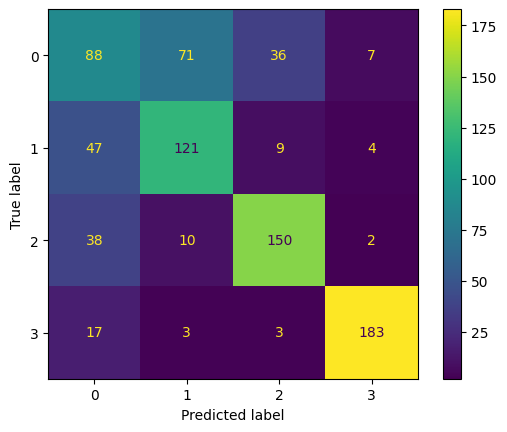

In [30]:
test_classifier(classifiers[2], train_params, *split_data)

### RandomForestClassifier

[21:08:11] {/tmp/ipykernel_89065/408107184.py:81} INFO - Parameter search for KNeighborsClassifier


n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 24
max_resources_: 3153
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 131
n_resources: 24
Fitting 3 folds for each of 131 candidates, totalling 393 fits
----------
iter: 1
n_candidates: 66
n_resources: 48
Fitting 3 folds for each of 66 candidates, totalling 198 fits
----------
iter: 2
n_candidates: 33
n_resources: 96
Fitting 3 folds for each of 33 candidates, totalling 99 fits
----------
iter: 3
n_candidates: 17
n_resources: 192
Fitting 3 folds for each of 17 candidates, totalling 51 fits
----------
iter: 4
n_candidates: 9
n_resources: 384
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 5
n_candidates: 5
n_resources: 768
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 3
n_resources: 1536
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 7
n_candidates: 2
n_resources: 3072
Fitting 

[21:10:39] {/tmp/ipykernel_89065/408107184.py:86} INFO - Best parameters for KNeighborsClassifier:
 {'weights': 'distance', 'p': 2, 'n_neighbors': 9, 'metric': 'chebyshev', 'leaf_size': 10}
[21:10:39] {/tmp/ipykernel_89065/408107184.py:87} INFO - Best estimator for KNeighborsClassifier:
 KNeighborsClassifier(leaf_size=10, metric='chebyshev', n_neighbors=9,
                     weights='distance')
[21:10:39] {/tmp/ipykernel_89065/408107184.py:105} INFO - Fitting KNeighborsClassifier
[21:10:39] {/tmp/ipykernel_89065/408107184.py:117} INFO - Train time: 147.62
[21:10:39] {/tmp/ipykernel_89065/408107184.py:54} INFO - Evaluation for KNeighborsClassifier


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.400000,0.540670,0.69,0.868293,0.632446,0.624741,0.628048
recall,0.346535,0.624309,0.69,0.864078,0.632446,0.631230,0.632446
f1-score,0.371353,0.579487,0.69,0.866180,0.632446,0.626755,0.629067
support,202.000000,181.000000,200.00,206.000000,0.632446,789.000000,789.000000


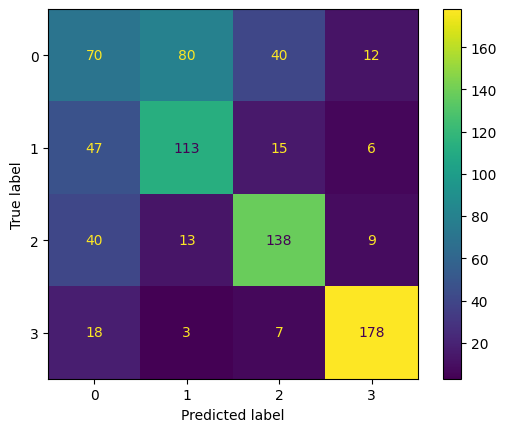

In [31]:
test_classifier(classifiers[3], train_params, *split_data)

### KNeighborsClassifier

[21:12:25] {/tmp/ipykernel_89065/408107184.py:81} INFO - Parameter search for RandomForestClassifier


n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 24
max_resources_: 3153
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 131
n_resources: 24
Fitting 3 folds for each of 131 candidates, totalling 393 fits
----------
iter: 1
n_candidates: 66
n_resources: 48
Fitting 3 folds for each of 66 candidates, totalling 198 fits
----------
iter: 2
n_candidates: 33
n_resources: 96
Fitting 3 folds for each of 33 candidates, totalling 99 fits
----------
iter: 3
n_candidates: 17
n_resources: 192
Fitting 3 folds for each of 17 candidates, totalling 51 fits
----------
iter: 4
n_candidates: 9
n_resources: 384
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 5
n_candidates: 5
n_resources: 768
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 3
n_resources: 1536
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 7
n_candidates: 2
n_resources: 3072
Fitting 

[21:18:14] {/tmp/ipykernel_89065/408107184.py:86} INFO - Best parameters for RandomForestClassifier:
 {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}
[21:18:14] {/tmp/ipykernel_89065/408107184.py:87} INFO - Best estimator for RandomForestClassifier:
 RandomForestClassifier(max_depth=20, min_samples_split=8, random_state=42)
[21:18:14] {/tmp/ipykernel_89065/408107184.py:105} INFO - Fitting RandomForestClassifier
[21:18:36] {/tmp/ipykernel_89065/408107184.py:117} INFO - Train time: 371.15
[21:18:36] {/tmp/ipykernel_89065/408107184.py:54} INFO - Evaluation for RandomForestClassifier


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.357143,0.522936,0.649289,0.88835,0.619772,0.604429,0.607924
recall,0.272277,0.629834,0.685000,0.88835,0.619772,0.618865,0.619772
f1-score,0.308989,0.571429,0.666667,0.88835,0.619772,0.608858,0.611125
support,202.000000,181.000000,200.000000,206.00000,0.619772,789.000000,789.000000


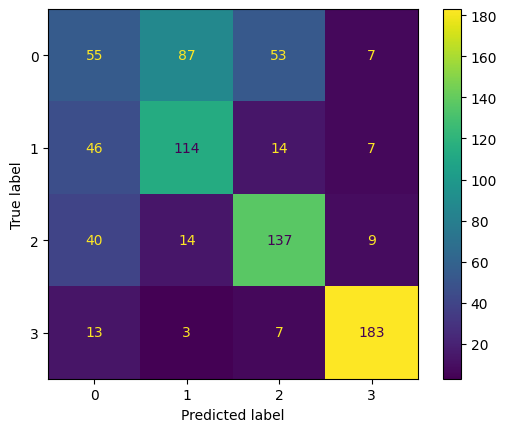

In [32]:
test_classifier(classifiers[4], train_params, *split_data)

### XGBoost

[21:20:21] {/tmp/ipykernel_89065/408107184.py:105} INFO - Fitting XGBClassifier
[21:21:27] {/tmp/ipykernel_89065/408107184.py:117} INFO - Train time: 65.49
[21:21:27] {/tmp/ipykernel_89065/408107184.py:54} INFO - Evaluation for XGBClassifier


,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.406780,0.559406,0.702970,0.889423,0.648923,0.639645,0.642886
recall,0.356436,0.624309,0.710000,0.898058,0.648923,0.647201,0.648923
f1-score,0.379947,0.590078,0.706468,0.893720,0.648923,0.642553,0.645061
support,202.000000,181.000000,200.000000,206.000000,0.648923,789.000000,789.000000


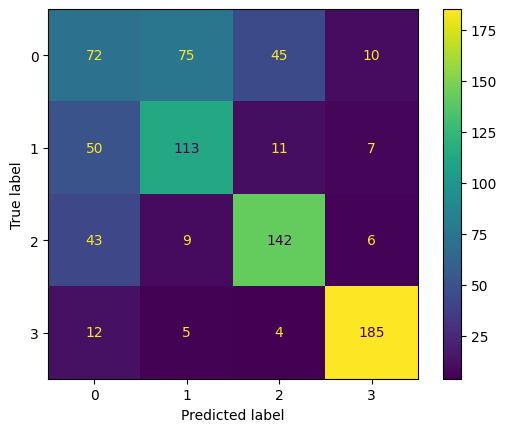

In [34]:
test_classifier(classifiers[5], train_params, *split_data)